In [1]:
from cmath import cos
from inspect import _void
import math
from sys import flags
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats
import scipy.signal as spsg
import os
from sklearn.cluster import KMeans
from scipy.spatial import distance
import time
import mat73
import os
from os.path import join
TMAX = 111 # Length of time series
NREGIONS = 82
basePath = "tDCS_timeseries"
awakePath = join(basePath, "timeseries_CoCoMac_tDCS_awake")
anesthPath = join(basePath, "timeseries_CoCoMac_tDCS_anesthesia")


In [2]:
# Angular difference function
def adif(a, b):
    return 2*math.pi-abs(a-b) if abs(a-b)>math.pi else abs(a-b)

In [3]:
awakeFnames = os.listdir(awakePath)
anesthFnames = os.listdir(anesthPath)
ts_all = np.zeros((len(awakeFnames)+len(anesthFnames),NREGIONS,TMAX))
for i,fn in enumerate(os.listdir(join(awakePath))):
    tmp = loadmat(join(awakePath,fn))
    ts_all[i, :, :] = np.swapaxes(tmp['scans'][:TMAX,:],0,1) 

for i,fn in enumerate(os.listdir(join(anesthPath))):
    tmp = loadmat(join(anesthPath,fn))
    ts_all[i+len(awakeFnames), :, :] = np.swapaxes(tmp['scans'][:TMAX,:],0,1) 
ts_all.shape

(554, 82, 111)

In [ ]:
#Data Anesthesia DBS
data_ts = loadmat('data_ts_DBS_CoCoMac_0.0025-0.05_Cleaned_Camilo_version.mat')
ts_aw=np.squeeze(data_ts['ts_aw'])  #36 scans
ts_off=np.squeeze(data_ts['ts_off']) #28 scans
ts_on_3V=np.squeeze(data_ts['ts_on_3V'])  #31 scans
ts_on_3V_control=np.squeeze(data_ts['ts_on_3V_control']) #18 scans
ts_on_5V=np.squeeze(data_ts['ts_on_5V'])  #25 scans
ts_on_5V_control=np.squeeze(data_ts['ts_on_5V_control']) #18 scans
ts_all = np.concatenate((ts_aw,ts_off,ts_on_3V,ts_on_3V_control,ts_on_5V,ts_on_5V_control),axis=0)

In [4]:
np.info(ts_all[0])

class:  ndarray
shape:  (82, 500)
strides:  (8, 656)
itemsize:  8
aligned:  True
contiguous:  False
fortran:  True
data pointer: 0x55ffa1c6efe0
byteorder:  little
byteswap:  False
type: float64


In [5]:
# Z-score
ts_all_zscored = np.zeros((len(ts_all),NREGIONS,TMAX)) # Storage for z-scored filtered signals
for i in range(len(ts_all)):
    ts_all_zscored[i]=np.array(stats.zscore(ts_all[i],axis=1))

In [6]:
# Detrend signal
for i in range(len(ts_all_zscored)):
    ts_all_zscored[i] = spsg.detrend(ts_all_zscored[i],type='linear')
# Demeaning signal
for i in range(len(ts_all_zscored)):
    ts_all_zscored[i] = ts_all_zscored[i]-np.mean(ts_all_zscored[i])
signal = np.array(ts_all_zscored)

In [7]:
# Reverse the signal, and Concatenation from both sides.
signal_rev = np.flip(signal, axis=2)
signal_rev_concat = np.concatenate((signal_rev, signal, signal_rev), axis=2)


# Butterworth filter parameters
n_order = 2
TR = 2.4 # in seconds
fnq = 1/(2*TR) # Nyquist frequency
low_f = 0.0025 # lower cutoff for bandpass filter
high_f = 0.05 # upper cutoff for bandpass filter
Wn = [low_f/fnq,high_f/fnq]
b,a = spsg.iirfilter(n_order,Wn,btype='bandpass',ftype='butter', output='ba')
# Apply Butterworth filter
filt_ts = np.empty_like(signal_rev_concat)
for i in range(len(ts_all_zscored)):
    filt_ts = spsg.filtfilt(b,a,signal_rev_concat,axis=1, padtype='odd', padlen=3*(max(len(b),len(a))-1))

In [8]:
# Now we can cut the signal back to its original size by taking the middle part
signal_filtered = filt_ts[:,:,len(signal_rev[0][0]):len(signal_rev[0][0])+len(signal[0][0])]

# And we can demean it again
signal_filtered = signal_filtered - np.mean(signal_filtered, axis=2, keepdims=True)


# Analytical continuation of our signal
analytic_signal = spsg.hilbert(signal_filtered)
amplitude_envelope = np.abs(analytic_signal)
instantaneous_phase = np.unwrap(np.angle(analytic_signal)) # Unwrap doesn't do anything?
# signal_reconstr = amplitude_envelope*np.cos(instantaneous_phase) # To ensure that we can reconstruct our initial signal from the hilbert transform

In [9]:
np.info(instantaneous_phase)

class:  ndarray
shape:  (554, 82, 111)
strides:  (72816, 888, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7ff2fdb67010
byteorder:  little
byteswap:  False
type: float64


In [10]:
# Now we can calculate the phase difference between each pair of regions using the adif function
# We will store the phase differences in a matrix of size (n_regions, n_regions, n_timepoints)
phase_diff = np.zeros((len(instantaneous_phase),len(instantaneous_phase[0]),len(instantaneous_phase[0]),len(instantaneous_phase[0][0])))
for ind in range(len(instantaneous_phase)):
    for t in range(len(instantaneous_phase[0][0])):
        for i in range(len(instantaneous_phase[0])):
            for j in range(len(instantaneous_phase[0])):
                if i==j:
                    phase_diff[ind,i,j,t] = 0
                else:
                    phase_diff[ind,i,j,t] = np.cos(adif(instantaneous_phase[ind][i][t], instantaneous_phase[ind][j][t]))

# Quite lengthy operation: hate those for loops :'(
# Find a way through numpy array handling

In [ ]:
len(instantaneous_phase[0])


6724

In [13]:
vector_size = len(np.triu_indices(instantaneous_phase.shape[1],1)[0])

In [19]:
len(instantaneous_phase[0][0])

111

In [20]:
# y = int(len(instantaneous_phase)*len(instantaneous_phase[0][0][0]))
# x = int(len(instantaneous_phase[0][0])/2*(len(instantaneous_phase[0][0])-1))
# Vectorize the superior triangular
vectorized = np.zeros((3321,61494))
for ind in range(len(instantaneous_phase)):
    for t in range(len(instantaneous_phase[0][0])):
        temp = np.array(())
        for j in range(len(instantaneous_phase[0])):
            for i in range(len(instantaneous_phase[0])):
                if i>j:
                    temp = np.append(temp,phase_diff[ind,i,j,t])
        temp.shape
        vectorized[:,ind*111+t] = temp

vectorized = vectorized.T
# Quite lengthy operation: hate those for loops :'(
# Maybe a way through numpy array handling
# Could probably actually do both the i>j and the cos(sigma_phi) at the same time...

In [25]:
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.kmeans import kmeans, kmeans_observer, kmeans_visualizer
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder
import pickle

2
3
4


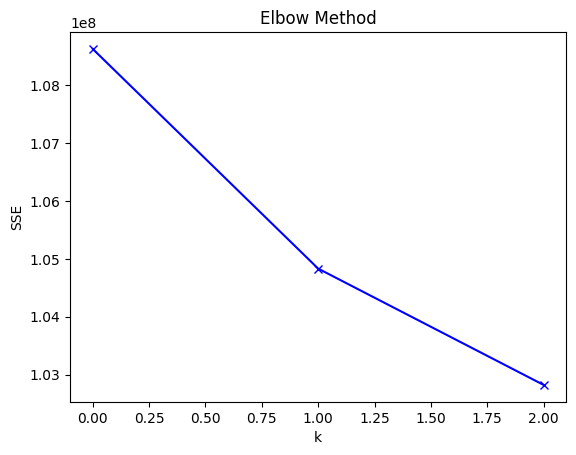

5


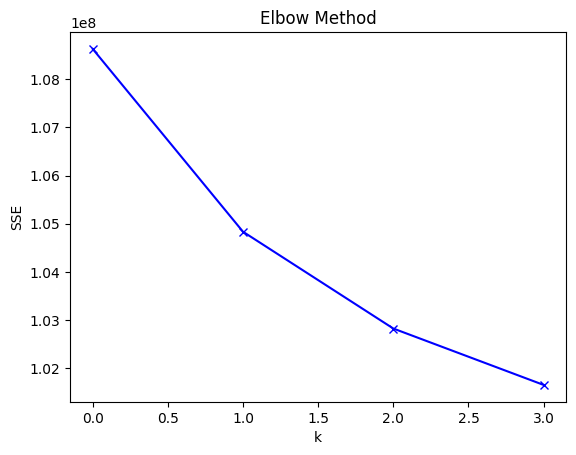

6


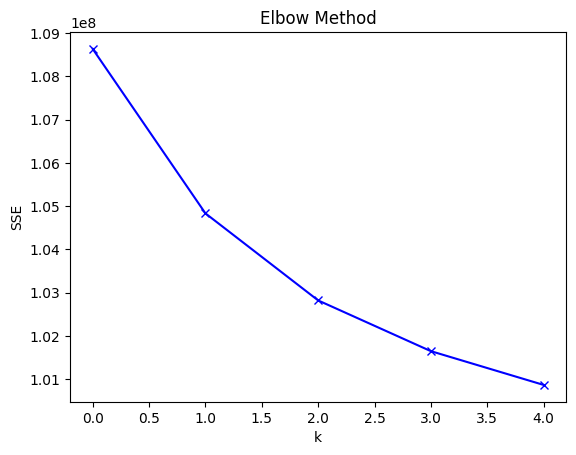

7


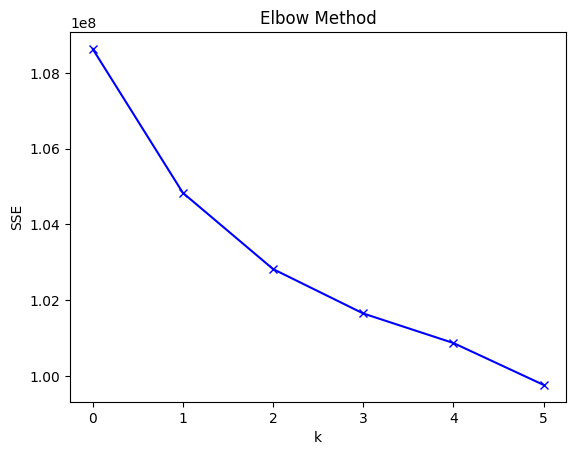

8


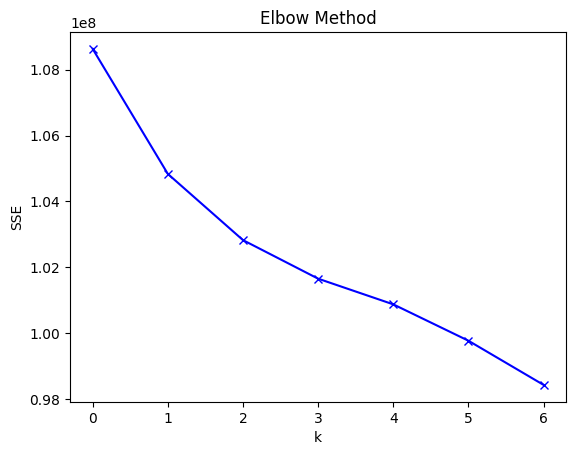

9


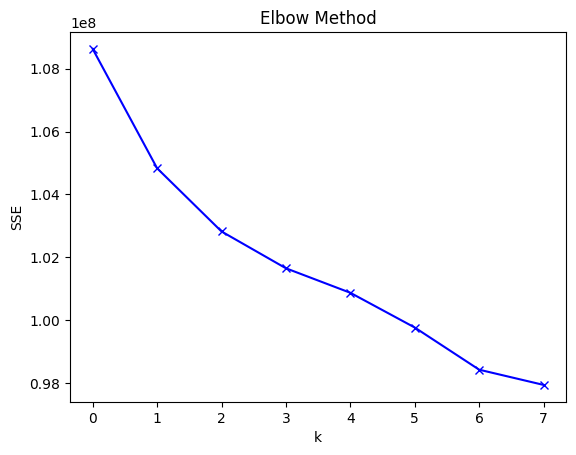

10


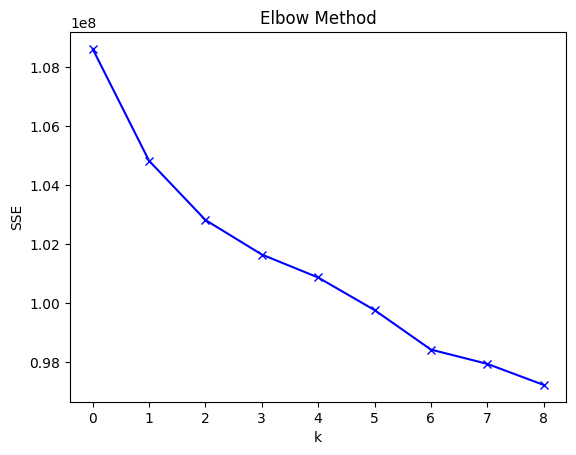

11


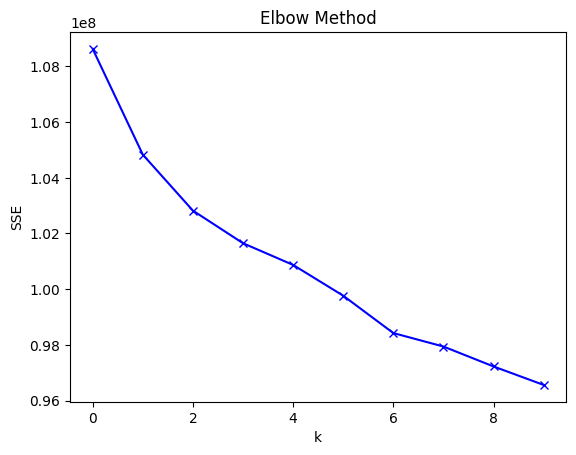

12


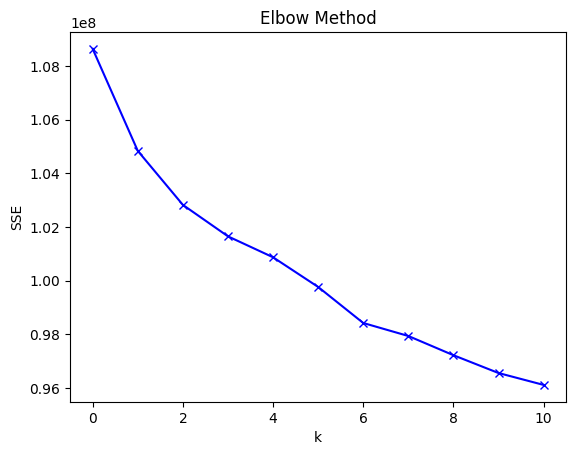

13


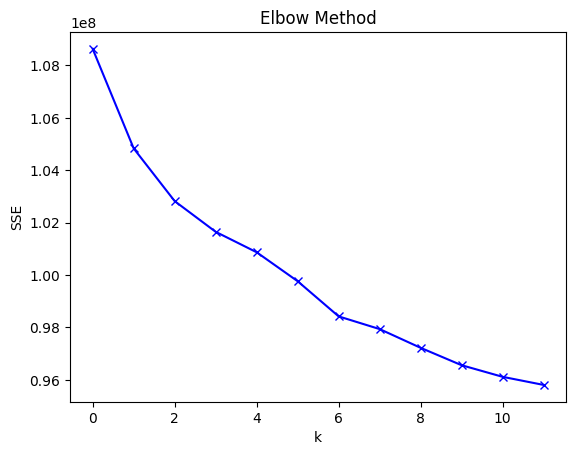

14


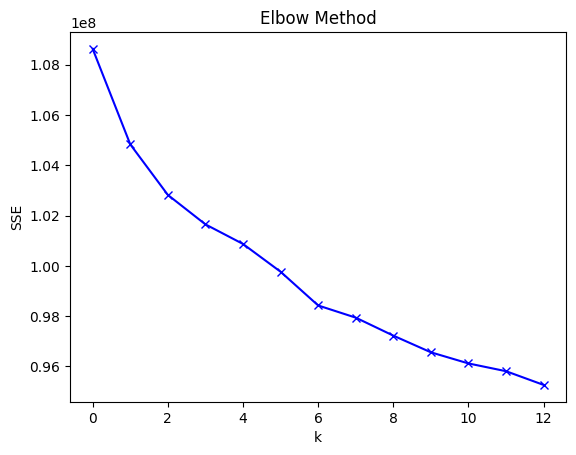

In [31]:
# TSCM K-Means
# AW+OFF+ON5V
labels = ()
centroids = ()
sse_values_high = []
for k in range(2,15):
    print(k)
    #kmeans = KMeans(n_clusters=k, random_state=1, n_init=500,init='random').fit(vectorized)
    #labels = kmeans.labels_
    #centroids_selv_pp = kmeans.cluster_centers_
    #np.save('TSCM_DBS_centroids k='+ str(k), centroids_selv_pp)    
    #np.save('TSCM_DBS_labels k='+ str(k), labels)

    initial_centers = random_center_initializer(vectorized, k, random_state=5).initialize()
    observer = kmeans_observer()
    instanceKm = kmeans(vectorized, observer=observer,initial_centers=initial_centers, metric=distance_metric(2))
    instanceKm.process()
    sse_values_high.append(instanceKm.get_total_wce())
    clusteroids = instanceKm.get_clusters()
    centroids = instanceKm.get_centers()
    # enumerate encoding type to index labeling to get labels
    pyEncoding = instanceKm.get_cluster_encoding()
    pyEncoder = cluster_encoder(pyEncoding, clusteroids, vectorized)
    labels = pyEncoder.set_encoding(0).get_clusters()

    with open(f"Results/Fored/k-{k}_centroids.pkl", 'wb') as f:
        pickle.dump(centroids, f)
    with open(f"Results/Fored/k-{k}_centroids.pkl", 'rb') as f:
        centroids = pickle.load(f)
    with open(f"Results/Fored/k-{k}_clusteroids.pkl", 'wb') as f:
        pickle.dump(clusteroids, f)
    with open(f"Results/Fored/k-{k}_clusteroids.pkl", 'rb') as f:
        clusteroids = pickle.load(f)
    with open(f"Results/Fored/k-{k}_Kmeans_model_pyclust.pkl", 'wb') as f:
        pickle.dump(instanceKm, f)
    with open(f"Results/Fored/k-{k}_Kmeans_model_pyclust.pkl", 'rb') as f:
        instanceKm = pickle.load(f)
    if len(sse_values_high)>2:
        plt.plot(range(len(sse_values_high)), sse_values_high, 'bx-')
        plt.xlabel('k')
        plt.ylabel('SSE')
        plt.title('Elbow Method')
        plt.show()

In [32]:
awake_experiment_names = {}
for i,fname in enumerate(os.listdir(awakePath)):
    name = fname.split("_")[4:] # First 3 words are timeseries - monkeyname - date
    exp_type = ("_").join(name[:-1])
    if exp_type not in awake_experiment_names.keys():
        awake_experiment_names[exp_type] = []
    awake_experiment_names[exp_type].append((fname,i))

anesth_experiment_names = {}
for i,fname in enumerate(os.listdir(anesthPath)):
    name = fname.split("_")[4:] # First 3 words are timeseries - monkeyname - date
    exp_type = ("_").join(name[:-1])
    if exp_type not in anesth_experiment_names.keys():
        anesth_experiment_names[exp_type] = []
    anesth_experiment_names[exp_type].append((fname,i))

In [35]:
# Angular difference function
def adif(a, b):
    return 2*math.pi-abs(a-b) if abs(a-b)>math.pi else abs(a-b) # HAY QUE AGREGAR EL COSENO DEPSPUES Y PONER EN 0 LA DIAGONAL
vec_adif = np.vectorize(adif,otypes=[np.ndarray])
def map_adif(t0xn):
    """ Takes a timepoint of all the nodes and generates the phase differenes for all of them
    Parameters
    ----------
    t0xn: np.array(1,N)
        One timesample of an original nodesxsteps timeseries
    Returns
    ----------
    np.array(N,N)
        NxN matrix of phase differences
    """    
    tmp = np.array(list(map(lambda node: np.cos(vec_adif(t0xn,node).astype(float)),t0xn)))            
    tmp = (tmp.T - np.eye(NREGIONS)).T    
    return tmp
    
def create_phase_dif(tss):
    """ Takes a whole trial and generates the phases differences for all timepointss
    Parameters
    ----------
    tss: np.array(M,N,T)
        A dataset of M trails of T steps registiring N channels or nodes
    Returns
    ----------
    np.array(M,N,N,T)
        MxNxNxT matrix of phase differences
        
    """
    return np.array(list(map(map_adif, tss)))
def flatten_matrices(tss):
    """ Flattens the dataset
    Parameters
    ---------
    tss: np.array(M,N,N,T)
        MxNxNxT dataset
    Returns
    ---------
    np.array(M*subdiag,T)
        All trials are concatenated and their upper triangular submatrices flattened
    """
    triu_idx = np.triu_indices(tss.shape[1],1)
    res = tss[:,triu_idx[0],triu_idx[1],:].swapaxes(1,2) # Change regions axis to time axis
    res = res.reshape((res.shape[0]*res.shape[1],res.shape[2])) # So we can pile trials x time
    return res

def reestructure_matrix(snapshot):    
    """ Recovers symetric phase difference matrix
    Parameters
    ----------
    snapshot: np.array(F)
        Flattened superior triangular matrix of a phase difference matrix
    Returns
    res: np.array(NREGIONS,NREGIONS)
        The original symetric matrix from which the flattned snapshot was captured
    """
    triu_idx = np.triu_indices(NREGIONS,1)    
    nxn_matrix_symmetric = np.zeros((NREGIONS,NREGIONS))
    nxn_matrix_symmetric[triu_idx[0],triu_idx[1]] = snapshot
    nxn_matrix_symmetric += nxn_matrix_symmetric.T
    return nxn_matrix_symmetric

def reestructure_dataset(proccessed_tss):
    """ Assumes the input is a set of trials processed as flattened phase differences and takes it back to trialsxNREGIONSxNREGIONSxTMAX    
    """
    n_trials = proccessed_tss.shape[0]//TMAX
    reestrctured = np.zeros((n_trials,NREGIONS,NREGIONS,TMAX))
    for i_trial in range(n_trials):
        for t in range(TMAX):
            reestrctured[i_trial,:,:,t] = reestructure_matrix(proccessed_tss[(i_trial*TMAX)+t,:])
    return reestrctured

def get_instant_phases(ts_all):    
    ts_all_zscored = np.zeros((len(ts_all),ts_all.shape[1],ts_all.shape[2])) # Storage for z-scored filtered signals
    for i in range(len(ts_all)):
        ts_all_zscored[i]=np.array(stats.zscore(ts_all[i],axis=1))
        ts_all_zscored[i] = spsg.detrend(ts_all_zscored[i],type='linear')
        ts_all_zscored[i] = ts_all_zscored[i]-np.mean(ts_all_zscored[i])    
    signal = np.array(ts_all_zscored)

    # Reverse the signal, and Concatenation from both sides.
    signal_rev = np.flip(signal, axis=2)
    signal_rev_concat = np.concatenate((signal_rev, signal, signal_rev), axis=2)
    # Butterworth filter parameters
    n_order = 2
    TR = 2.4 # in seconds
    fnq = 1/(2*TR) # Nyquist frequency
    low_f = 0.0025 # lower cutoff for bandpass filter
    high_f = 0.05 # upper cutoff for bandpass filter
    Wn = [low_f/fnq,high_f/fnq]
    b,a = spsg.iirfilter(n_order,Wn,btype='bandpass',ftype='butter', output='ba')
    # Apply Butterworth filter
    filt_ts = np.empty_like(signal_rev_concat)
    #for i in range(len(ts_all_zscored)): # NOT NECESSARY 
    #    filt_ts = spsg.filtfilt(b,a,signal_rev_concat,axis=1, padtype='odd', padlen=3*(max(len(b),len(a))-1))
    filt_ts = spsg.filtfilt(b,a,signal_rev_concat,axis=1, padtype='odd', padlen=3*(max(len(b),len(a))-1))

    # Now we can cut the signal back to its original size by taking the middle part
    signal_filtered = filt_ts[:,:,len(signal_rev[0][0]):len(signal_rev[0][0])+len(signal[0][0])]

    # And we can demean it again
    signal_filtered = signal_filtered - np.mean(signal_filtered, axis=2, keepdims=True)


    # Analytical continuation of our signal
    analytic_signal = spsg.hilbert(signal_filtered)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal)) # Unwrap doesn't do anything?
    # signal_reconstr = amplitude_envelope*np.cos(instantaneous_phase) # To ensure that we can reconstruct our initial signal from the hilbert transform
    return instantaneous_phase
def get_vectoried(input_phase):
    # Now we can calculate the phase difference between each pair of regions using the adif function
    # We will store the phase differences in a matrix of size (n_regions, n_regions, n_timepoints)
    phase_diff_tmp = np.zeros((len(input_phase),len(input_phase[0]),len(input_phase[0]),len(input_phase[0][0])))
    for ind in range(len(input_phase)):
        for t in range(len(input_phase[0][0])):
            for i in range(len(input_phase[0])):
                for j in range(len(input_phase[0])):
                    if i==j:
                        phase_diff_tmp[ind,i,j,t] = 0
                    else:
                        phase_diff_tmp[ind,i,j,t] = np.cos(adif(input_phase[ind][i][t], input_phase[ind][j][t]))

    # Quite lengthy operation: hate those for loops :'(
    # Find a way through numpy array handling

    # y = int(len(input_phase)*len(input_phase[0][0][0]))
    # x = int(len(input_phase[0][0])/2*(len(input_phase[0][0])-1))
    # Vectorize the superior triangular
    vector_size = len(np.triu_indices(input_phase.shape[1],1)[0])
    
    vectorized = np.zeros((vector_size,input_phase.shape[0]*input_phase.shape[2]))    
    for ind in range(len(input_phase)):
        for t in range(len(input_phase[0][0])):
            temp = np.array(())
            for j in range(len(input_phase[0])):
                for i in range(len(input_phase[0])):
                    if i>j:
                        temp = np.append(temp,phase_diff_tmp[ind,i,j,t])        
            vectorized[:,(ind*input_phase.shape[2])+t] = temp

    vectorized = vectorized.T
    return vectorized



def get_phases(input_phase):
    # Now we can calculate the phase difference between each pair of regions using the adif function
    # We will store the phase differences in a matrix of size (n_regions, n_regions, n_timepoints)
    phase_diff_tmp = np.zeros((len(input_phase),len(input_phase[0]),len(input_phase[0]),len(input_phase[0][0])))
    for ind in range(len(input_phase)):
        for t in range(len(input_phase[0][0])):
            for i in range(len(input_phase[0])):
                for j in range(len(input_phase[0])):
                    if i==j:
                        phase_diff_tmp[ind,i,j,t] = 0
                    else:
                        phase_diff_tmp[ind,i,j,t] = np.cos(adif(input_phase[ind][i][t], input_phase[ind][j][t]))
    return phase_diff_tmp

import multiprocessing as mp
def process_parallelized(data):
    n_proc = mp.cpu_count()
    chunk_size = data.shape[0]//n_proc
    proc_chunks = []
    for i_proc in range(n_proc):
        chunkstart = i_proc*chunk_size
        chunkend = (i_proc+1)*chunk_size if i_proc < n_proc -1 else None
        proc_chunks.append(data[chunkstart:chunkend, :, :])

    assert sum(map(len,proc_chunks)) == data.shape[0]
    if __name__=='__main__':
        def process_chunk(proc_chunk):
            chunk_res = np.array(list(map(map_adif, proc_chunk)))    
            chunk_res.index = proc_chunk.index
            return chunk_res
        with mp.Pool(processes=n_proc) as pool:
            proc_results = [pool.apply_async(process_chunk,args=(chunk,)) for chunk in proc_chunks]
            result_chunks = [r.get() for r in proc_results]
    return result_chunks



#inst_ph = get_instant_phases(awake_experiments['anesthesia'])
#vectorized_dif_ph = create_phase_dif(inst_ph)

In [ ]:
from math import ceil,sqrt
#centroids = np.load("./results/Fored/TS_ALL_centroids.npy")
triu_idx = np.triu_indices(NREGIONS,1)
tril_idx = np.tril_indices(NREGIONS,-1)
# Create a figure with 7 subplots arranged in a 2x4 grid
for k in range(2,15):
    num_plots = k
    num_cols = ceil(sqrt(num_plots))
    num_rows = ceil(num_plots / num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 6))

    with open(f"Results/Fored/k-{k}_centroids.pkl", 'rb') as f:
        centroids = pickle.load(f)
    with open(f"Results/Fored/k-{k}_clusteroids.pkl", 'rb') as f:
        clusteroids = pickle.load(f)
    with open(f"Results/Fored/k-{k}_Kmeans_model_pyclust.pkl", 'rb') as f:
        instanceKm = pickle.load(f)


    # Plot each centroid on a separate subplot
    print("Plotting heatmaps")
    for i in range(k):
        # Choose the subplot for this centroid
        ax = axs.flatten()[i]
        
        # Plot the heatmap for this centroid
        im = ax.imshow(reestructure_matrix(centroids[i]), cmap='hot')
        # Set the title for this subplot
        ax.set_title('Centroid {}'.format(i+1))
        # Add a colorbar to show the heatmap values
        cbar = ax.figure.colorbar(im, ax=ax)
        cbar.ax.set_ylabel('Intensity', rotation=-90, va="bottom")
        
    # Adjust the layout of the subplots
    plt.tight_layout()

    # Show the figure
    plt.show()
    fig.savefig(f"plots/Fored/{k}centroids.png")
    # With pyclustering output 
    # This is basically an intersect between set of ids for each exp type and each clusteroid. The result of the seven intersections if what I want
    anesth_exp_clust_counts = dict.fromkeys(anesth_experiment_names.keys())

    for exp_type in anesth_experiment_names.keys():
        anesth_exp_clust_counts[exp_type] = []
        for fname_i in anesth_experiment_names[exp_type]:
            found = False
            c_i = 0
            cur_id = fname_i[1]
            while not found or c_i>k-1:
                if cur_id in clusteroids[c_i]:
                    found=True
                    anesth_exp_clust_counts[exp_type].append(c_i)
                else:
                    c_i+=1
            if c_i>k-1:
                raise(Exception)
            

    awake_exp_clust_counts = dict.fromkeys(awake_experiment_names.keys())

    for exp_type in awake_experiment_names.keys():
        awake_exp_clust_counts[exp_type] = []
        for fname_i in awake_experiment_names[exp_type]:
            found = False
            c_i = 0
            cur_id = fname_i[1]
            while not found or c_i>k-1:
                if cur_id in clusteroids[c_i]:
                    found=True
                    awake_exp_clust_counts[exp_type].append(c_i)
                else:
                    c_i+=1
            if c_i>k-1:
                raise(Exception)
            
    from collections import defaultdict
    from math import ceil, sqrt
    counter = defaultdict(int)


    num_plots = len(awake_exp_clust_counts)
    num_cols = ceil(sqrt(num_plots))
    num_rows = ceil(num_plots / num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 10))

    for i,exp_type in enumerate(awake_exp_clust_counts.keys()):
        #cur_labels = [single_label for trial_labels in exp_results[exp_type] for single_label in trial_labels]
        row = i // num_cols
        col = i % num_cols
        cur_labels = awake_exp_clust_counts[exp_type]
        #for label in cur_labels:
        #    counter[label]+=1
        weights = np.ones_like(cur_labels) / len(cur_labels)
        offset = 0.5
        bins = np.linspace(-offset, k-offset, k+1)
        # Generate a histogram plot of the predicted values on the appropriate subplot
        axs[row,col].hist(cur_labels, weights=weights, bins=bins, rwidth=0.75)
        axs[row,col].set_xticks(range(k))
        axs[row,col].set_title(exp_type)
        axs[row,col].set_xlabel('Cluster')
        axs[row,col].set_ylabel('Frequency')
        #axs[i].set_ylim(0,0.35)

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Show the figure
    plt.show()
    fig.savefig(f"plots/Fored/distributions_{k}clusters_awake.png")


In [ ]:
from collections import defaultdict
from math import ceil, sqrt
counter = defaultdict(int)

for k in range(2,15):
    num_plots = len(anesth_exp_clust_counts)
    num_cols = ceil(sqrt(num_plots))
    num_rows = ceil(num_plots / num_cols)
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 10))

    for i,exp_type in enumerate(anesth_exp_clust_counts.keys()):
        #cur_labels = [single_label for trial_labels in exp_results[exp_type] for single_label in trial_labels]
        row = i // num_cols
        col = i % num_cols
        cur_labels = anesth_exp_clust_counts[exp_type]
        #for label in cur_labels:
        #    counter[label]+=1
        weights = np.ones_like(cur_labels) / len(cur_labels)
        offset = 0.5
        bins = np.linspace(-offset, k-offset, k+1)
        # Generate a histogram plot of the predicted values on the appropriate subplot
        axs[row,col].hist(cur_labels, weights=weights, bins=bins, rwidth=0.75)
        axs[row,col].set_xticks(range(k))
        axs[row,col].set_title(exp_type)
        axs[row,col].set_xlabel('Cluster')
        axs[row,col].set_ylabel('Frequency')
        #axs[i].set_ylim(0,0.35)

    # Adjust the layout of the subplots
    plt.tight_layout()

    # Show the figure
    plt.show()
    fig.savefig(f"plots/Fored/distributions_{k}clusters_anesth.png")


In [45]:
awake_counts = {}
anesth_counts = {}

for k in range(2,15):
    with open(f"Results/Fored/k-{k}_clusteroids.pkl", 'rb') as f:
        clusteroids = pickle.load(f)
    anesth_counts[k] = dict.fromkeys(anesth_experiment_names.keys())
    for exp_type in anesth_experiment_names.keys():
        anesth_counts[k][exp_type] = []
        for fname_i in anesth_experiment_names[exp_type]:
            found = False
            c_i = 0
            cur_id = fname_i[1]
            while not found or c_i>k-1:
                if cur_id in clusteroids[c_i]:
                    found=True
                    anesth_counts[k][exp_type].append(c_i)
                else:
                    c_i+=1
            if c_i>k-1:
                raise(Exception)
            

    awake_counts[k] = dict.fromkeys(awake_experiment_names.keys())

    for exp_type in awake_experiment_names.keys():
        awake_counts[k][exp_type] = []
        for fname_i in awake_experiment_names[exp_type]:
            found = False
            c_i = 0
            cur_id = fname_i[1]
            while not found or c_i>k-1:
                if cur_id in clusteroids[c_i]:
                    found=True
                    awake_counts[k][exp_type].append(c_i)
                else:
                    c_i+=1
            if c_i>k-1:
                raise(Exception)
            
    

In [76]:
anesth_states = []
awake_sates = []

In [82]:
len(awake_counts[3]['baseline_awake'])

82

In [83]:
clusteroids

[[22,
  23,
  24,
  25,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  50,
  51,
  52,
  102,
  103,
  104,
  131,
  132,
  133,
  149,
  165,
  166,
  167,
  168,
  169,
  181,
  182,
  279,
  280,
  281,
  326,
  327,
  377,
  485,
  486,
  487,
  488,
  489,
  490,
  491,
  492,
  552,
  553,
  745,
  787,
  788,
  952,
  953,
  954,
  955,
  956,
  957,
  958,
  959,
  969,
  970,
  971,
  972,
  999,
  1000,
  1001,
  1024,
  1025,
  1026,
  1027,
  1028,
  1029,
  1036,
  1037,
  1038,
  1039,
  1040,
  1058,
  1059,
  1060,
  1061,
  1092,
  1107,
  1108,
  1109,
  1118,
  1119,
  1120,
  1121,
  1122,
  1123,
  1131,
  1132,
  1133,
  1134,
  1135,
  1136,
  1137,
  1138,
  1154,
  1155,
  1175,
  1176,
  1177,
  1178,
  1179,
  1202,
  1203,
  1204,
  1205,
  1206,
  1207,
  1292,
  1323,
  1324,
  1325,
  1326,
  1374,
  1375,
  1376,
  1377,
  1378,
  1421,
  1451,
  1452,
  1453,
  1460,
  1461,
  1462,
  1463,
  1520,
  1521,
  1522,
  1617,
  1618,
  1619,
  1622,
  1623,
  

In [61]:
anesth_experiment_names.keys()

dict_keys(['sham_1mA_anesthesia', 'post_st_2mA_anesthesia', 'stim_1mA_anesthesia', 'awake', 'sham_2mA_anesthesia', 'post_st_1mA_anesthesia', 'baseline_anesthesia', 'stim_2mA_anesthesia', 'post_sh_1mA_anesthesia', 'post_sh_2mA_anesthesia'])

In [ ]:
from collections import Counter
from math import ceil, sqrt
least_comm_clust = []
most_comm_clust = []
for k in range(3,15):
    with open(f"Results/Fored/k-{k}_centroids.pkl", 'rb') as f:
        centroids = pickle.load(f)
    print(f">>>>>>> {k} >>>>>>>>> ")
    counter = {i:0 for i in range(k)}
    for exp_type in anesth_experiment_names.keys():
        for c_i in anesth_counts[k][exp_type]:
            counter[c_i]+=1
        if exp_type =='baseline_anesthesia':
            #print(Counter(counter).most_common()[-2:-1][0][0])
            #print(Counter(counter).most_common(1)[0][0])
            continue       
        least_comm_clust.append(Counter(counter).most_common()[-2:-1][0][0])
        most_comm_clust.append(Counter(counter).most_common(1)[0][0])
    print(f"Least common cluster: {Counter(least_comm_clust).most_common(1)[0][0]}")
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.imshow(reestructure_matrix(centroids[Counter(least_comm_clust).most_common(1)[0][0]]),cmap='hot')
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Intensity', rotation=-90, va="bottom")
    plt.show()
    #print(f"Most common cluster {Counter(most_comm_clust).most_common(1)[0][0]}")
    #fig = plt.figure()
    #ax = fig.add_subplot(111)
    #plt.imshow(reestructure_matrix(centroids[Counter(most_comm_clust).most_common(1)[0][0]]),cmap='hot')
    #plt.show()
    
    

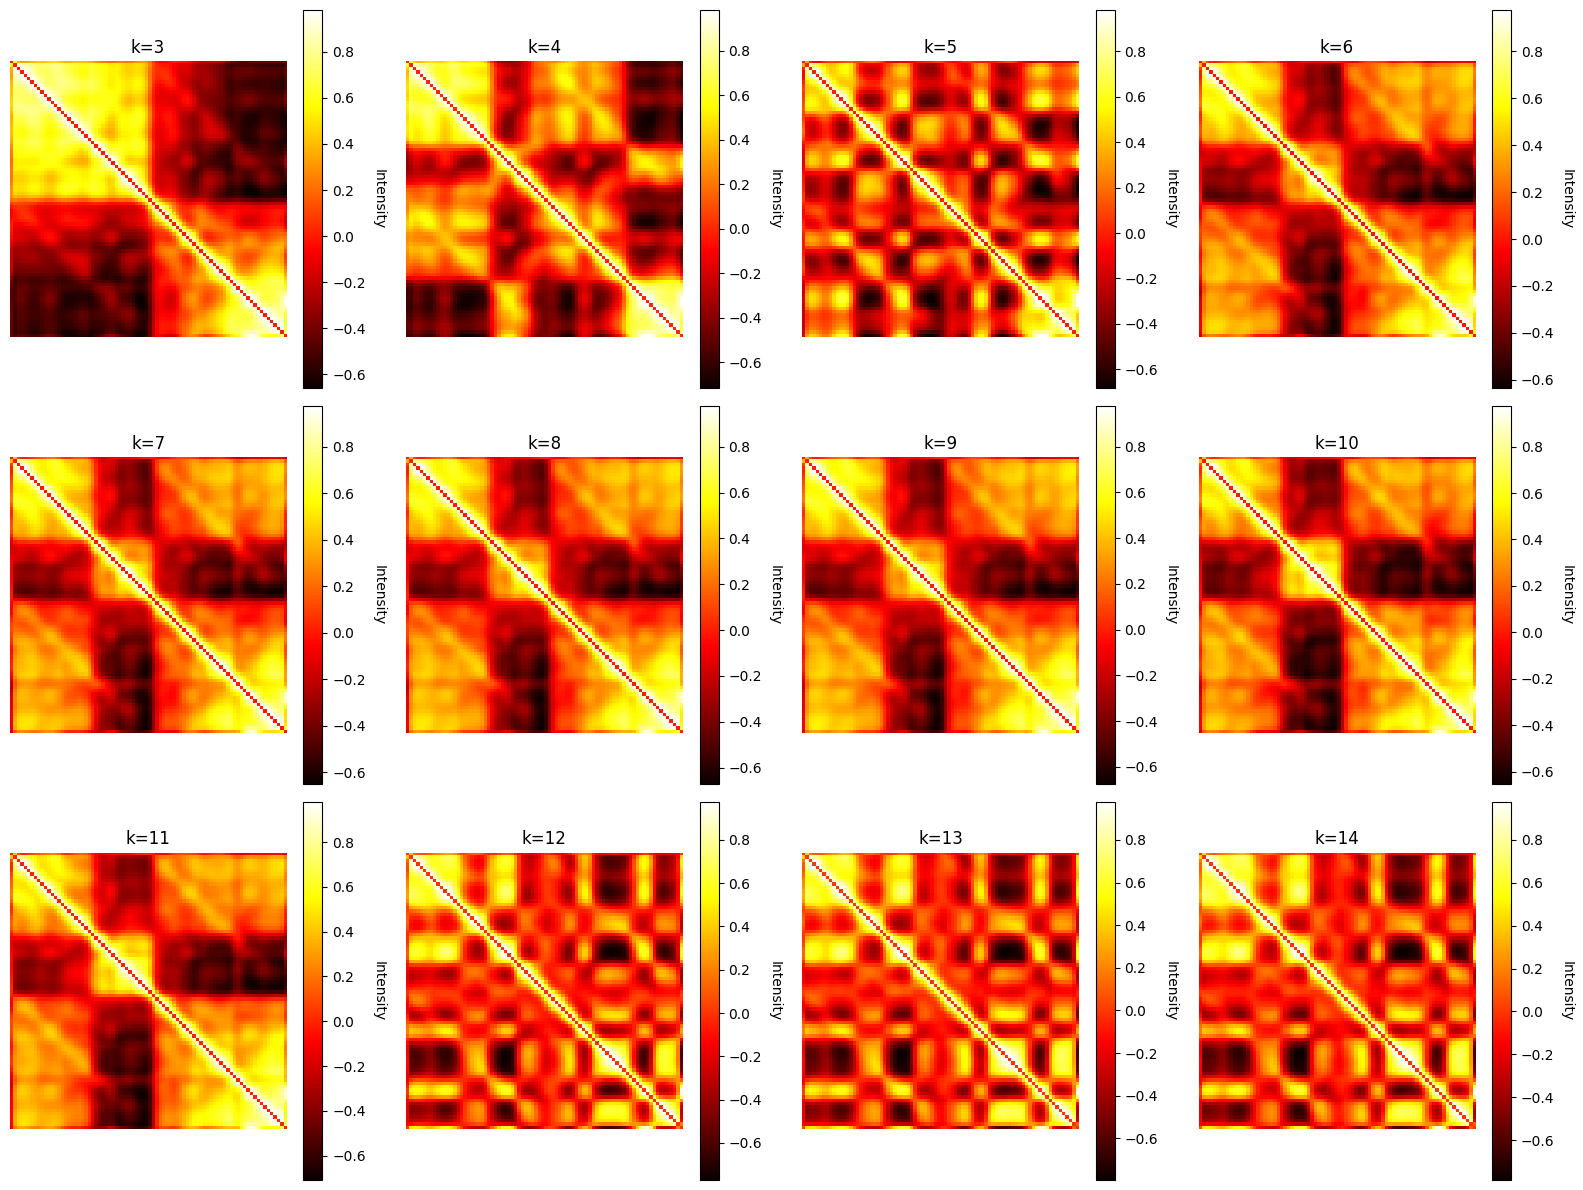

In [72]:
from collections import Counter
from math import ceil, sqrt
import matplotlib.pyplot as plt

least_comm_clust = []
most_comm_clust = []

fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
axs = axs.flatten()

for i, k in enumerate(range(3,15)):
    with open(f"Results/Fored/k-{k}_centroids.pkl", 'rb') as f:
        centroids = pickle.load(f)
    
    counter = {i:0 for i in range(k)}
    for exp_type in anesth_experiment_names.keys():
        for c_i in anesth_counts[k][exp_type]:
            counter[c_i]+=1
        if exp_type =='baseline_anesthesia':
            continue       
        least_comm_clust.append(Counter(counter).most_common()[-2:-1][0][0])
        most_comm_clust.append(Counter(counter).most_common(1)[0][0])
    #print(f"Least common cluster: {Counter(least_comm_clust).most_common(1)[0][0]}")
    
    ax = axs[i]
    im = ax.imshow(reestructure_matrix(centroids[Counter(least_comm_clust).most_common(1)[0][0]]), cmap='hot')
    cbar = fig.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Intensity', rotation=-90, va="bottom")
    ax.set_title(f"k={k}")
    ax.axis('off')

plt.tight_layout()
plt.show()


In [73]:
SC = np.load("cocomac82.npy")

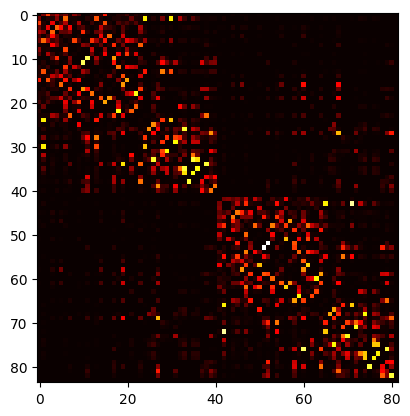

In [75]:
plt.imshow(SC, cmap="hot")

In [ ]:
# TSCM K-Means
# AW+OFF+ON5V
    
_5V_vector = np.concatenate((vectorized[:,0:32000], vectorized[:,56500:69000]), axis=1)

    
labels_5V = ()
centroids_5V = ()

k=7
kmeans_5V = KMeans(n_clusters=k, random_state=1, n_init=500,init='random').fit(_5V_vector)
labels_5V = kmeans_5V.labels_
centroids_selv_pp = kmeans_5V.cluster_centers_
np.save('TSCM_DBS_centroids_5V k='+ str(k), centroids_5V)    
np.save('TSCM_DBS_labels_5V k='+ str(k), labels_5V)

In [13]:
# Concatenate only awake, lpp and dpp for k-means
# TSCM K-Means
# AW+OFF+ON5VC
    
_5VC_vector = np.concatenate((vectorized[:,0:32000], vectorized[:,69000:78000]), axis=1)

    
labels_5VC = ()
centroids_5VC = ()

k=7
kmeans_5VC = KMeans(n_clusters=k, random_state=1, n_init=500,init='random').fit(_5VC_vector)
labels_5VC = kmeans_5VC.labels_
centroids_selv_pp = kmeans_5VC.cluster_centers_
np.save('TSCM_DBS_centroids_5VC k='+ str(k), centroids_5VC)    
np.save('TSCM_DBS_labels_5VC k='+ str(k), labels_5VC)

In [14]:
Time_per_rec = len(ts_all[0][0])
N=len(ts_all[0])
Total_patient = len(ts_all)
Leading_Eig = np.empty((Total_patient*Time_per_rec,N))
for ind in range(Total_patient):
    for t in range(Time_per_rec):
            eigenvalues, eigenvectors = np.linalg.eig(phase_diff[ind,:,:,t])
            
            V1 = eigenvectors[:, np.argmax(eigenvalues)]
            
            mean_positive = np.mean(V1 > 0)

            if mean_positive > 0.5:
                V1 = -V1
            elif mean_positive == 0.5 and np.sum(V1[V1 > 0]) > -np.sum(V1[V1 < 0]):
                V1 = -V1
            Leading_Eig[Time_per_rec*ind+t] = V1

/opt/miniconda/envs/jupyterhub/lib/python3.6/site-packages/ipykernel_launcher.py:17: ComplexWarning: Casting complex values to real discards the imaginary part


In [15]:
_5V_vec = np.concatenate((Leading_Eig[:,0:32000], Leading_Eig[:,56500:69000]), axis=1)

# K-Means 5V
                                          
labels_aw_pp = ()
centroids_aw_pp = ()

k=7
kmeans_5V = KMeans(n_clusters=k, random_state=1, n_init=500,init='random').fit(_5V_vec)
labels_5V = kmeans_5V.labels_
centroids_5V = kmeans_5V.cluster_centers_
np.save('centroids_DBS_LEiDA_5V k='+ str(k), centroids_5V)    
np.save('labels_DBS_LEiDA_5V k='+ str(k), labels_5V)

In [16]:
_5VC_vec = np.concatenate((Leading_Eig[:,0:32000], Leading_Eig[:,69000:78000]), axis=1)

# K-Means 5VC
                                          
labels_aw_pp = ()
centroids_aw_pp = ()

k=7
kmeans_5VC = KMeans(n_clusters=k, random_state=1, n_init=500,init='random').fit(_5VC_vec)
labels_5VC = kmeans_5VC.labels_
centroids_5VC = kmeans_5VC.cluster_centers_
np.save('centroids_DBS_LEiDA_5VC k='+ str(k), centroids_5VC)    
np.save('labels_DBS_LEiDA_5VC k='+ str(k), labels_5VC)

In [40]:
len(labels_5VC)

82

In [41]:
np.info(_5VC_vec)

class:  ndarray
shape:  (78000, 82)
strides:  (656, 8)
itemsize:  8
aligned:  True
contiguous:  True
fortran:  False
data pointer: 0x7f44405b5010
byteorder:  little
byteswap:  False
type: float64
